# CBB Head-to-Head Predictor — Naive Bayes (Gaussian)
*Generated on 2025-10-26 04:05:35*

This notebook builds a **head-to-head** model from `newPastCBB.csv` using the `LostTo` column to create game-level data.
It trains a **Gaussian Naive Bayes** model on **pairwise difference features** and provides symmetric predictions with a same-team 50/50 rule.


In [1]:
# Imports
import re
import pandas as pd
import numpy as np
from difflib import get_close_matches

from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt

PAST_PATH = "newPastCBB.csv"
CURRENT_PATH = "cbb25.csv"


In [2]:
# Load CSVs
past = pd.read_csv(PAST_PATH)
current = pd.read_csv(CURRENT_PATH)

# Drop common auto-index column if present
for df in (past, current):
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)

print('Past shape:', past.shape)
print('Current shape:', current.shape)
display(past.head(5))
display(current.head(5))

Past shape: (1079, 30)
Current shape: (68, 24)


,Team,Conf,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,3P%D,3PR,3PRD,ADJ_T,WAB,Win%,Year,TeamText,matched_official_team,LostTo
0,2011_Ohio_St_,B10,37,34,126.010,91.811,0.97421,56.3200,48.3126,15.8700,...,34.0147,32.7171,34.6231,63.8246,11.710,0.918919,2011,Ohio St,Ohio St,2011_Kentucky
1,2011_Kansas,B12,38,35,120.940,91.060,0.96332,57.0100,44.5110,19.1111,...,29.8900,32.4179,34.6231,68.0480,10.220,0.921053,2011,Kansas,Kansas,2011_VCU
2,2011_Duke,ACC,37,32,120.650,91.580,0.96003,53.7170,44.5110,17.2290,...,32.4580,35.3113,24.5500,68.5380,9.330,0.864865,2011,Duke,Duke,2011_Arizona
3,2011_Texas,B12,36,28,115.521,90.020,0.94604,50.2108,42.5300,17.3310,...,29.5600,25.5324,26.1120,65.5157,5.413,0.777778,2011,Texas,Texas,2011_Arizona
4,2011_Kentucky,SEC,38,29,119.370,93.422,0.94375,52.3410,44.2900,16.1100,...,32.4580,32.4179,29.7720,64.8191,5.215,0.763158,2011,Kentucky,Kentucky,2011_Connecticut


,Team,Conf,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTR,FTRD,2P%,2P%D,3P%,3P%D,3PR,3PRD,ADJ_T,WAB
0,Houston,B12,34,30,124.89,88.010,0.98231,52.788,44.940,14.6250,...,27.2328,34.2216,47.8295,44.550,39.430,30.214,34.7285,43.4313,61.8360,11.52
1,Duke,ACC,34,31,128.52,91.340,0.98082,57.450,44.530,14.4190,...,32.9182,25.0170,57.9800,43.030,38.670,31.137,44.6580,38.3157,66.0272,9.55
2,Auburn,SEC,33,28,129.11,93.712,0.97563,55.725,46.011,13.4600,...,33.9152,38.7310,55.7330,46.829,35.966,29.890,40.8136,35.3600,68.3133,12.71
3,Florida,SEC,34,30,127.73,94.013,0.97144,55.037,45.360,15.0360,...,34.9121,32.5167,56.1290,46.317,35.673,29.450,43.7720,37.2119,69.9590,11.23
4,Alabama,SEC,33,25,127.64,96.428,0.96205,56.314,47.950,16.7149,...,39.3300,33.2187,59.7400,49.095,35.393,30.419,46.6340,34.6420,75.1100,10.14


In [3]:
# Build matchup dataset from LostTo

# Identify numeric columns and choose features (exclude 'Result' which is an outcome)
numeric_cols = [c for c in past.columns if pd.api.types.is_numeric_dtype(past[c])]
leaky = {'Result'}  # optionally add 'G','W','Win%' to avoid leakage
feature_stats = [c for c in numeric_cols if c not in leaky]

if 'LostTo' not in past.columns:
    raise ValueError("Expected 'LostTo' column in past data.")

games = past.dropna(subset=['LostTo']).copy()

opp_table = past[['Team'] + feature_stats].rename(columns={'Team': 'OppTeam'})
games = games.merge(opp_table, left_on='LostTo', right_on='OppTeam', how='inner', suffixes=('', '_opp'))

print('Matched games:', games.shape[0])
if games.shape[0] == 0:
    raise RuntimeError("No games matched between LostTo and Team.")

pair_features = []
for c in feature_stats:
    if c + '_opp' in games.columns:
        games[f'diff_{c}'] = games[c] - games[c + '_opp']
        pair_features.append(f'diff_{c}')

print('Pairwise feature count:', len(pair_features))
if len(pair_features) == 0:
    raise RuntimeError("No pairwise features were created.")

games['label'] = 0
flip = pd.DataFrame({'Team': games['OppTeam'], 'OppTeam': games['Team'], 'label': 1})
for f in pair_features:
    flip[f] = -games[f]

pair_df = pd.concat([games[['Team','OppTeam','label'] + pair_features], flip], ignore_index=True)
print('Pairwise dataset shape:', pair_df.shape)
display(pair_df.head())

Matched games: 735
Pairwise feature count: 24
Pairwise dataset shape: (1470, 27)


,Team,OppTeam,label,diff_G,diff_W,diff_ADJOE,diff_ADJDE,diff_BARTHAG,diff_EFG_O,diff_EFG_D,...,diff_2P%,diff_2P%D,diff_3P%,diff_3P%D,diff_3PR,diff_3PRD,diff_ADJ_T,diff_WAB,diff_Win%,diff_Year
0,2011_Ohio_St_,2011_Kentucky,0,-1,5,6.640,-1.611,0.030460,3.9790,4.0226,...,4.0997,4.4530,2.5200,1.5567,0.2992,4.8511,-0.9945,6.495,0.155761,0
1,2011_Kansas,2011_VCU,0,-2,7,8.300,-8.850,0.163759,5.8380,-4.7062,...,8.7937,-4.1785,1.1690,-3.7218,-8.8041,4.5451,2.9306,12.199,0.221053,0
2,2011_Duke,2011_Arizona,0,-1,2,1.870,-6.487,0.059610,-0.3950,-4.1026,...,1.4760,-7.3115,-2.3450,3.1280,-0.8767,-3.7900,3.6190,4.714,0.075391,0
3,2011_Texas,2011_Arizona,0,-2,-2,-3.259,-8.047,0.045620,-3.9012,-6.0836,...,-2.9242,-8.4775,-2.1540,0.2300,-10.6556,-2.2280,0.5967,0.797,-0.011696,0
4,2011_Kentucky,2011_Connecticut,0,-3,-3,3.552,-0.201,0.023637,4.1199,-0.2210,...,1.0947,0.0000,6.8666,-0.3140,3.0922,-2.4435,0.5962,-1.595,-0.017330,0


5-fold CV accuracy (GaussianNB): 0.816 +/- 0.015

Confusion Matrix
 [[600 135]
 [136 599]]

Accuracy: 0.816

Classification Report:
                       precision    recall  f1-score   support

First team loses (0)       0.82      0.82      0.82       735
 First team wins (1)       0.82      0.81      0.82       735

            accuracy                           0.82      1470
           macro avg       0.82      0.82      0.82      1470
        weighted avg       0.82      0.82      0.82      1470



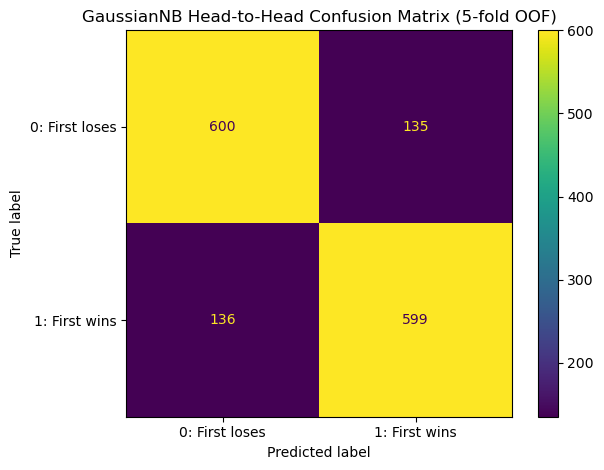

Training complete. Features used: 24


In [4]:
# Train Gaussian Naive Bayes and evaluate

X_cols = [c for c in pair_df.columns if c.startswith('diff_')]
X = pair_df[X_cols].copy()
y = pair_df['label'].astype(int).values

pre = ColumnTransformer([('num', SimpleImputer(strategy='median'), X_cols)])
nb_model = Pipeline([('pre', pre), ('nb', GaussianNB())])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(nb_model, X, y, cv=cv, scoring='accuracy')
print('5-fold CV accuracy (GaussianNB):', round(scores.mean(), 3), '+/-', round(scores.std(), 3))

y_pred_oof = cross_val_predict(nb_model, X, y, cv=cv, method='predict')
cm = confusion_matrix(y, y_pred_oof, labels=[0,1])
acc = accuracy_score(y, y_pred_oof)
print("\nConfusion Matrix\n", cm)
print("\nAccuracy:", round(acc, 3))
print("\nClassification Report:\n", classification_report(y, y_pred_oof, target_names=['First team loses (0)', 'First team wins (1)']))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0: First loses','1: First wins'])
fig, ax = plt.subplots()
disp.plot(ax=ax, values_format='d')
plt.title("GaussianNB Head-to-Head Confusion Matrix (5-fold OOF)")
plt.tight_layout()
plt.show()

nb_model.fit(X, y)
FEATURE_LIST = X_cols
print('Training complete. Features used:', len(FEATURE_LIST))

In [5]:
# Helpers: resolve team names and symmetric prediction

def _normalize_name(s: str) -> str:
    return re.sub(r'[_\s]+', ' ', str(s).strip().lower())

def resolve_team(name: str, df: pd.DataFrame) -> str:
    if 'Team' not in df.columns:
        raise ValueError("DataFrame must include a 'Team' column.")
    typed = name.strip()
    teams = df['Team'].astype(str).tolist()

    if typed in teams:
        return typed
    lower_map = {t.lower(): t for t in teams}
    if typed.lower() in lower_map:
        return lower_map[typed.lower()]
    norm_map = {_normalize_name(t): t for t in teams}
    n = _normalize_name(typed)
    if n in norm_map:
        return norm_map[n]
    cand = [t for t in teams if n in _normalize_name(t)]
    if len(cand) == 1:
        return cand[0]
    if len(cand) > 1:
        print("Multiple matches found for", repr(typed), "->", cand[:10])
        best = get_close_matches(typed, cand, n=1)
        if best:
            return best[0]
    best = get_close_matches(typed, teams, n=1)
    if best:
        print(f"Did you mean '{best[0]}'? Using that.")
        return best[0]
    raise ValueError(f"Team '{name}' not found in current['Team'].")

def _build_diff_vector(current_df: pd.DataFrame, team_a: str, team_b: str, feature_list):
    if 'Team' not in current_df.columns:
        raise ValueError("current_df must include a 'Team' column.")
    if team_a not in set(current_df['Team']) or team_b not in set(current_df['Team']):
        raise ValueError("Both team names must exist in current_df['Team'].")
    A = current_df[current_df['Team'] == team_a].iloc[0]
    B = current_df[current_df['Team'] == team_b].iloc[0]

    row = {}
    for f in feature_list:
        base = f.replace('diff_', '')
        a_has = base in A.index
        b_has = base in B.index
        if a_has and b_has:
            try:
                row[f] = float(A[base]) - float(B[base])
            except Exception:
                row[f] = np.nan
        elif (not a_has) and (not b_has):
            row[f] = 0.0
        else:
            row[f] = np.nan
    return pd.DataFrame([row])

def predict_match_winner_nb(current_df: pd.DataFrame, team_a: str, team_b: str, fitted_model, feature_list):
    if team_a == team_b:
        return {'winner': team_a, 'prob_A_wins': 0.5, 'prob_B_wins': 0.5}

    X_ab = _build_diff_vector(current_df, team_a, team_b, feature_list)
    p_ab = float(fitted_model.predict_proba(X_ab)[0][1])

    X_ba = _build_diff_vector(current_df, team_b, team_a, feature_list)
    p_ba = float(fitted_model.predict_proba(X_ba)[0][1])

    pA = 0.5 * (p_ab + (1.0 - p_ba))
    pB = 1.0 - pA
    winner = team_a if pA >= 0.5 else team_b
    return {'winner': winner, 'prob_A_wins': pA, 'prob_B_wins': pB}

In [6]:
# Demo (edit names)
TEAM_A_NAME = "Florida"
TEAM_B_NAME = "Houston"

TEAM_A = resolve_team(TEAM_A_NAME, current)
TEAM_B = resolve_team(TEAM_B_NAME, current)

print('TEAM_A =', TEAM_A)
print('TEAM_B =', TEAM_B)

res = predict_match_winner_nb(current, TEAM_A, TEAM_B, nb_model, FEATURE_LIST)
print('\nPredicted winner:', res['winner'])
print('P(TEAM_A wins):', round(res['prob_A_wins'], 3))
print('P(TEAM_B wins):', round(res['prob_B_wins'], 3))

TEAM_A = Florida
TEAM_B = Houston

Predicted winner: Florida
P(TEAM_A wins): 0.6
P(TEAM_B wins): 0.4


In [10]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

COLUMNS_TO_SHOW = ["Team", "OppTeam", "label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_df = pair_df.iloc[X_train.index][COLUMNS_TO_SHOW]
test_df  = pair_df.iloc[X_test.index][COLUMNS_TO_SHOW]

t.head(10)


,Team,OppTeam,label
345,2021_Virginia,2021_Ohio,0
315,2014_Colorado,2014_Pittsburgh,0
251,2019_Oregon,2019_Virginia,0
646,2023_UCLA,2023_Gonzaga,0
99,2024_Howard,2024_Wagner,0
128,2018_Rhode_Island,2018_Duke,0
807,2024_Houston,2024_Texas_A_M,1
105,2018_West_Virginia,2018_Villanova,0
35,2011_Michigan_St_,2011_UCLA,0
991,2019_Oklahoma,2019_Mississippi,1
